# Capstone Project - Top Tourist Destinations in Queens, New York
### Applied Data Science Capstone by IBM/Coursera
#### Authored By: Olusola Adekunle

## Table of contents
* [Introduction: Buisness Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## 1. Introduction: Business Problem <a name="introduction"></a>

   Founded in 1683, Queens is the one of the lively, vibrant and largest borough in New York. Queens Borough is located on Long Island cross the East River from Manhattan with notable tourist attractions like; Flushing Meadows-Corona Park or the Queens Botanical Garden, the parks Queens Museum is known for the "Panorama," a building-for-building model of New York City, Nearby Citi Field is the stadium of pro baseball team, the Mets and many more. 
    Queens is the easternmost of the other five boroughs in New York, is adjacent to the borough of Brooklyn at the southwestern end of Long Island. Due to her uniqueness and beauty, Queens has been unarguably one of New York best boroughs for new residents to make their homes and also a scenery tourist destination. Many parts of Queens have a more suburban feel and offer the perfect retreat from the bright lights and bustling streets of nearby Manhattan.

 This project evaluates the neighborhoods in Queens for people intending to visit; either to start a business or for pleasure. More importantly I try to highlights peculiarity of the neighborhoods and opportunities available for intending business owners and pleasure seekers.
Over the years, there have been increasing number of people visiting the borough and realizing what a great destination it is. There's history, culture, views, and food without the high prices as seen in other New York borough and this project will make every visit a memorable one.



In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.timeout.com/images/100650551/1024/576/image.jpg")

## 1. Data <a name="Data"></a>

While exploring the diversity of the Queens, I required;
1. Neighbourhoods in Queens. This define the scope of the project
2. Latitude and Longitude coordinates of those neighbourhood. This is required to plot maps and provide venue data
3. Queens public spatial data

Data Sources

Queens data shows list of Queens neighbourhood together with spatial locations
https://geo.nyu.edu/catalog/nyu-2451-34572

	
In addition, Foursquare API will be used to get the venue and venue category data of the Queens neighborhood.

In [3]:
pip install geopy

     |████████████████████████████████| 102kB 17.0MB/s ta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
Note: you may need to restart the kernel to use updated packages.


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim 
import requests 
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

##  Download and Explore Queens Dataset

New York has a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the latitude and longitude coordinates of each neighborhood. 

#### Load and explore the data

Next, let's load the data.

In [5]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [6]:
#newyork_data

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [7]:
Neighbourhoods_data = newyork_data["features"]

Let's take a look at the first item in this list.

In [8]:
Neighbourhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}




#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
Neighbourhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [10]:
Neighbourhoods

,Borough,Neighbourhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [11]:
for data in Neighbourhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    Neighbourhoods =  Neighbourhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [13]:
Neighbourhoods.head()

,Borough,Latitude,Longitude,Neighborhood
0,Bronx,40.894705,-73.847201,Wakefield
1,Bronx,40.874294,-73.829939,Co-op City
2,Bronx,40.887556,-73.827806,Eastchester
3,Bronx,40.895437,-73.905643,Fieldston
4,Bronx,40.890834,-73.912585,Riverdale


In [12]:
Neighbourhoods.drop('Neighbourhood',axis=1, inplace=True)

In [14]:

Neigh = Neighbourhoods.groupby('Borough')

Neigh['Borough'].count()

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Borough, dtype: int64

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [21]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Neighbourhoods['Borough'].unique()),
        Neighbourhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Queens, New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [22]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queen New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queen New York City are 40.6524927, -73.7914214158161.


In [23]:
Queens_data = Neighbourhoods[Neighbourhoods['Borough'] == 'Queens'].reset_index(drop=True)
Queens_data.head()

,Borough,Latitude,Longitude,Neighborhood
0,Queens,40.768509,-73.915654,Astoria
1,Queens,40.746349,-73.901842,Woodside
2,Queens,40.751981,-73.882821,Jackson Heights
3,Queens,40.744049,-73.881656,Elmhurst
4,Queens,40.654225,-73.838138,Howard Beach


In [24]:
# create map of New York using latitude and longitude values
map_Queens = folium.Map(location=[latitude, longitude], zoom_start=30)

# add markers to map
for lat, lng, borough, neighborhood in zip(Neighbourhoods['Latitude'], Neighbourhoods['Longitude'], Neighbourhoods['Borough'], Neighbourhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Queens)  
    
map_Queens

Utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = 'RW4XGCMOCEKL00BKEERHL2U5HTQVNT2HS05SKAWUEHUAVIAH' # your Foursquare ID
CLIENT_SECRET = '1CTRYLXJEFSKRJUEFXQ0KHYLJ2E03NIHVKHO1WIN0HF4JABS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RW4XGCMOCEKL00BKEERHL2U5HTQVNT2HS05SKAWUEHUAVIAH
CLIENT_SECRET:1CTRYLXJEFSKRJUEFXQ0KHYLJ2E03NIHVKHO1WIN0HF4JABS


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [29]:
Queens_data.loc[0, 'Neighborhood']

'Astoria'

Get the neighborhood's latitude and longitude values.

In [30]:
neighborhood_latitude = Queens_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Queens_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Queens_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Astoria are 40.76850859335492, -73.91565374304234.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [31]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

#create URL

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# display URL 
url




'https://api.foursquare.com/v2/venues/explore?&client_id=RW4XGCMOCEKL00BKEERHL2U5HTQVNT2HS05SKAWUEHUAVIAH&client_secret=1CTRYLXJEFSKRJUEFXQ0KHYLJ2E03NIHVKHO1WIN0HF4JABS&v=20180605&ll=40.76850859335492,-73.91565374304234&radius=500&limit=100'

Send the GET request and examine the resutls

In [32]:
results = requests.get(url).json()
#results

In [43]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [44]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Favela Grill,Brazilian Restaurant,40.767348,-73.917897
1,CrossFit Queens,Gym,40.769404,-73.918977
2,Titan Foods Inc.,Gourmet Shop,40.769198,-73.919253
3,Orange Blossom,Gourmet Shop,40.769856,-73.917012
4,Simply Fit Astoria,Gym,40.769114,-73.912403


And how many venues were returned by Foursquare?

In [45]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


<a id='item2'></a>

## 3. Methodology

#### Let's create a function to repeat the same process to all the neighborhoods in Queens

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the Foursquare API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [47]:
Queens_venues = getNearbyVenues(names=Queens_data['Neighborhood'],
                                   latitudes=Queens_data['Latitude'],
                                   longitudes=Queens_data['Longitude']
                                  )



Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


#### Let's check the size of the resulting dataframe

In [48]:
print(Queens_venues.shape)
Queens_venues.head(20)


(2169, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym
5,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
6,Astoria,40.768509,-73.915654,Sitan Muay Thai,40.766108,-73.913224,Martial Arts Dojo
7,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
8,Astoria,40.768509,-73.915654,Irish Rover,40.765835,-73.914647,Pub
9,Astoria,40.768509,-73.915654,Noisette,40.768544,-73.911248,Dessert Shop


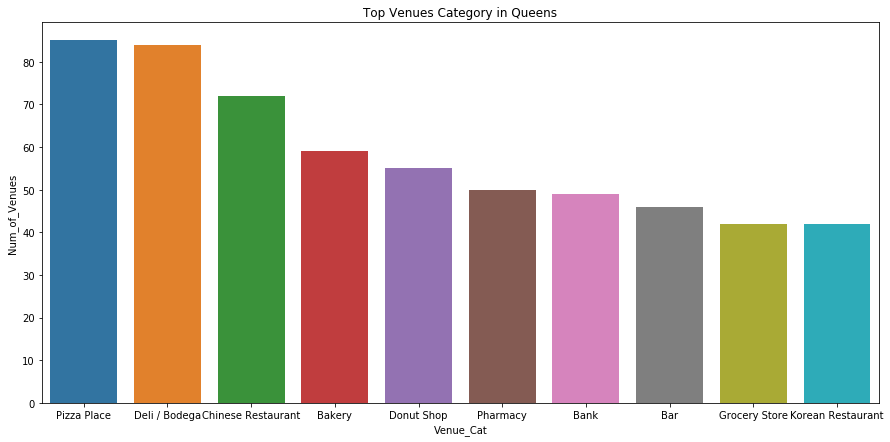

,Venue_Cat,Num_of_Venues
263,Arts & Entertainment,1
264,Bike Rental / Bike Share,1
265,Check Cashing Service,1
266,Other Nightlife,1
267,Falafel Restaurant,1
268,German Restaurant,1
269,Pedestrian Plaza,1
270,Hotel Pool,1
271,Bookstore,1
272,Butcher,1


In [49]:
#Queens_venues['Venue'].value_counts()
Venue_data = Queens_venues['Venue Category'].value_counts().rename_axis("Venue_cat").reset_index("Venue_cat")
Venue_data.columns = ["Venue_Cat", "Num_of_Venues"]
#columns = ['Venue_Category','Number_of_Venue']
Top_10_Venues = Venue_data.head(10)
Least_10_Venues = Venue_data.tail(10)
#Venue = pd.DataFrame(data=Venue_data, columns=columns)

#Venue.head()
plt.figure(figsize=(15, 7))
sns.barplot(x='Venue_Cat', y='Num_of_Venues', data=Top_10_Venues).set_title('Top Venues Category in Queens')
#Top_10_Venues.plot.bar(x='Venue_Cat', y='Num_of_Venues', figsize=(15, 7))
#plt.title('Venues Category in Queens')
#plt.ylabel('Num_of_Venues')
#plt.xlabel('Venue_Cat')
plt.show()

#sns.barplot(x='Venue_Cat', y='Num_of_Venues', data=Least_10_Venues).set_title('Least Venues Category in Queens')

Least_10_Venues.tail(30)

In [50]:
Extract = Queens_venues[['Neighborhood', 'Venue Category',]]

In [52]:
Extract.head()

,Neighborhood,Venue Category
0,Astoria,Brazilian Restaurant
1,Astoria,Gym
2,Astoria,Gourmet Shop
3,Astoria,Gourmet Shop
4,Astoria,Gym


Let's check how many venues were returned for each neighborhood

In [53]:
Queens_venues.groupby('Neighborhood').count().sort_values(by='Venue Category')

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Somerville,1,1,1,1,1,1
Brookville,1,1,1,1,1,1
Bayswater,2,2,2,2,2,2
Malba,3,3,3,3,3,3
Glendale,4,4,4,4,4,4
Jamaica Estates,4,4,4,4,4,4
Holliswood,4,4,4,4,4,4
Neponsit,5,5,5,5,5,5
Whitestone,6,6,6,6,6,6


#### Let's find out how many unique categories can be curated from all the returned venues

In [54]:
print('There are {} uniques categories.'.format(len(Queens_venues['Venue Category'].unique())))

There are 273 uniques categories.


<a id='item3'></a>

## 4. Analysis; Analyze Each Queens Neighborhood

In [55]:
# one hot encoding
Queens_onehot = pd.get_dummies(Queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Queens_onehot['Neighborhood'] = Queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Queens_onehot.columns[-1]] + list(Queens_onehot.columns[:-1])
Queens_onehot = Queens_onehot[fixed_columns]

Queens_onehot.head(10)

,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,W

In [56]:
Queens_onehot.shape

(2169, 273)

#### Next step is grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [57]:
Queens_grouped = Queens_onehot.groupby('Neighborhood').mean().reset_index()
Queens_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,W

#### Let's confirm the new size

In [58]:
Queens_grouped.shape

(81, 273)

#### Let's print each neighborhood along with the top 4 most common venues

In [60]:
num_top_venues = 4

for hood in Queens_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Queens_grouped[Queens_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arverne----
             venue  freq
0        Surf Spot  0.22
1   Sandwich Place  0.11
2    Metro Station  0.11
3  Thai Restaurant  0.06


----Astoria----
                       venue  freq
0  Middle Eastern Restaurant  0.07
1                        Bar  0.06
2                 Hookah Bar  0.05
3           Greek Restaurant  0.05


----Astoria Heights----
                venue  freq
0       Bowling Alley  0.08
1              Bakery  0.08
2  Italian Restaurant  0.08
3         Bus Station  0.08


----Auburndale----
               venue  freq
0     Ice Cream Shop  0.06
1  Korean Restaurant  0.06
2     Discount Store  0.06
3           Pharmacy  0.06


----Bay Terrace----
            venue  freq
0  Clothing Store  0.12
1   Women's Store  0.05
2      Kids Store  0.05
3  Lingerie Store  0.05


----Bayside----
                 venue  freq
0                  Bar  0.08
1   Mexican Restaurant  0.04
2          Pizza Place  0.04
3  American Restaurant  0.04


----Bayswater----
         venue  fre

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each Queens neighborhood.

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Queens_grouped['Neighborhood']

for ind in np.arange(Queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Sandwich Place,Pizza Place,Wine Shop,Playground,Beach,Thai Restaurant,Donut Shop,Bus Stop
1,Astoria,Middle Eastern Restaurant,Bar,Greek Restaurant,Hookah Bar,Seafood Restaurant,Deli / Bodega,Café,Bakery,Grocery Store,Pub
2,Astoria Heights,Playground,Italian Restaurant,Burger Joint,Bowling Alley,Bus Station,Supermarket,Bakery,Cocktail Bar,Food,Plaza
3,Auburndale,Miscellaneous Shop,Fast Food Restaurant,Noodle House,Korean Restaurant,Supermarket,Furniture / Home Store,Discount Store,Italian Restaurant,Toy / Game Store,Athletics & Sports
4,Bay Terrace,Clothing Store,Women's Store,Kids Store,Donut Shop,Mobile Phone Shop,Shoe Store,Lingerie Store,Cosmetics Shop,American Restaurant,Video Game Store


<a id='item4'></a>

##  Clustering Queens Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [39]:
# set number of clusters
kclusters = 5

Queens_grouped_clustering = Queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Queens_merged = Queens_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Queens_merged = Queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Queens_merged.head() # check the last columns!

,Borough,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,40.768509,-73.915654,Astoria,0,Middle Eastern Restaurant,Bar,Greek Restaurant,Hookah Bar,Seafood Restaurant,Deli / Bodega,Café,Bakery,Grocery Store,Pub
1,Queens,40.746349,-73.901842,Woodside,0,Grocery Store,Thai Restaurant,Bakery,Filipino Restaurant,Latin American Restaurant,Pizza Place,Bar,American Restaurant,Donut Shop,Pub
2,Queens,40.751981,-73.882821,Jackson Heights,0,Latin American Restaurant,Mexican Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Diner,Mobile Phone Shop,Spanish Restaurant,Thai Restaurant,Supplement Shop
3,Queens,40.744049,-73.881656,Elmhurst,0,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indonesian Restaurant,South American Restaurant,Bubble Tea Shop,Malay Restaurant,Bar,Bank
4,Queens,40.654225,-73.838138,Howard Beach,0,Italian Restaurant,Fast Food Restaurant,Pharmacy,Bagel Shop,Sandwich Place,Seafood Restaurant,Supermarket,Sporting Goods Shop,Fried Chicken Joint,Breakfast Spot


Finally, let's visualize the resulting clusters

In [123]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Queens_merged['Latitude'], Queens_merged['Longitude'], Queens_merged['Neighborhood'], Queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## Clusters Examination

Now, lets examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster.

#### Cluster 1

In [42]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 0, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,40.768509,Middle Eastern Restaurant,Bar,Greek Restaurant,Hookah Bar,Seafood Restaurant,Deli / Bodega,Café,Bakery,Grocery Store,Pub
1,40.746349,Grocery Store,Thai Restaurant,Bakery,Filipino Restaurant,Latin American Restaurant,Pizza Place,Bar,American Restaurant,Donut Shop,Pub
2,40.751981,Latin American Restaurant,Mexican Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Diner,Mobile Phone Shop,Spanish Restaurant,Thai Restaurant,Supplement Shop
3,40.744049,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Indonesian Restaurant,South American Restaurant,Bubble Tea Shop,Malay Restaurant,Bar,Bank
4,40.654225,Italian Restaurant,Fast Food Restaurant,Pharmacy,Bagel Shop,Sandwich Place,Seafood Restaurant,Supermarket,Sporting Goods Shop,Fried Chicken Joint,Breakfast Spot
5,40.742382,Mexican Restaurant,Pizza Place,Italian Restaurant,Convenience Store,Supermarket,Empanada Restaurant,Liquor Store,Sandwich Place,South American Restaurant,Bakery
6,40.725264,Gym,Gym / Fitness Center,Yoga Studio,Pizza Place,Park,Thai Restaurant,Pharmacy,Convenience Store,Business Service,Snack Place
7,40.705179,Chinese Restaurant,Indian Restaurant,Bar,Bank,Pharmacy,Pizza Place,Donut Shop,Food,Fried Chicken Joint,Spa
8,40.697947,Discount Store,Pizza Place,Lounge,Deli / Bodega,Latin American Restaurant,Caribbean Restaurant,Bank,Cosmetics Shop,Metro Station,Spanish Restaurant
9,40.764454,Chinese Restaurant,Bubble Tea Shop,Hotpot Restaurant,Korean Restaurant,Bakery,Food,Karaoke Bar,Seafood Restaurant,Szechuan Restaurant,Asian Restaurant


#### Cluster 2

In [43]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 1, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,40.597711,Park,Women's Store,Farm,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Dumpling Restaurant
79,40.611322,Playground,Park,Women's Store,Farm,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market


#### Cluster 3

In [44]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 2, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,40.557401,Beach,Monument / Landmark,American Restaurant,Board Shop,Trail,Women's Store,Fast Food Restaurant,Event Space,Falafel Restaurant,Farm
50,40.572037,Beach,Beach Bar,Women's Store,Farmers Market,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant,Egyptian Restaurant
78,40.587338,Beach,Southern / Soul Food Restaurant,Diner,Café,Gym / Fitness Center,Shoe Store,Dog Run,Fast Food Restaurant,Bus Stop,Bus Station


#### Cluster 4

In [45]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 3, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,40.603027,Deli / Bodega,Other Nightlife,Pizza Place,Dive Bar,Park,Women's Store,Falafel Restaurant,Electronics Store,Empanada Restaurant,Event Space
64,40.660003,Deli / Bodega,Women's Store,Fast Food Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Filipino Restaurant


#### Cluster 5

In [46]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 4, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,40.790602,Rest Area,Latin American Restaurant,Tennis Court,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Women's Store


## Result and Discussion <a name="Discussion"></a>


Exploratory analysis shows that Astoria, Sunnyside Gardens, Jackson Heights, Woodside are the most vibrant neighborhoods in Queens due to the number of venues in each of this neighborhood. This apparently mean visitors and tourist are attracted to these neighborhoods. These neighborhoods among other things have high number of Museums, restaurants, ice cream shops, gyms and gourmet.

However, some neighborhood shows very low number of venues for anyone intending to visit Queens, but this analysis has shown it’s an opportunity to create business for such neighborhood.
Examples of these neighborhood are; somerville, Brookville, Baywaters, Malba to name a few.
The population of these neighborhoods are on the rise and certainly and new venues like Butchery, Dessert and ice cream venues, Credit centers, Chinese restaurants, middle east restaurants and gift shops to serve the growing population of these neighborhood.


## Conclusion <a name="Conclusion"></a>


This analysis will be very important for individuals who intend to relocate or visit Queens for either business or pleasure but would like to identify the right neighborhood in the borough of. In addition, tourists and real estate agents can benefit from this analysis. The results can be further improved on if neighborhood attribute information is available for all the data instance of type of business, cost of doing business data from other years is also analyzed and average cost of houses in each of the neighborhood is put into consideration as part of the analysis.